In [106]:
# encoding=utf8
import sys

# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import re
from afinn import Afinn

reload(sys)
sys.setdefaultencoding('utf8')

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [3]:
tweet_list = pd.read_csv('Data/train.csv', dtype={'keyword':'str'})
tweet_list.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [4]:
tweet_list.info()

In [5]:
tweet_list.keyword.fillna('', inplace=True)
tweet_list.location.fillna('', inplace=True)
tweet_list.text.fillna('', inplace=True)
#tweet_list.tail()

# Comparacion de repetidos por target

In [6]:
text_list = tweet_list.groupby(['text','target']).size().reset_index(name='count')
repeated = text_list[text_list['count']>1].sort_values(by='count', ascending=False)
repeated[repeated.target==1].describe()

,target,count
count,45.00,45.00
mean,1.00,2.44
std,0.00,1.41
min,1.00,2.00
25%,1.00,2.00
50%,1.00,2.00
75%,1.00,2.00
max,1.00,10.00


In [7]:

repeated[repeated.target==0].describe()

,target,count
count,20.00,20.00
mean,0.00,2.35
std,0.00,0.67
min,0.00,2.00
25%,0.00,2.00
50%,0.00,2.00
75%,0.00,2.25
max,0.00,4.00


### Observacion
Se observa una marcada tendencia de repeticion de tweets verdaderos 

# Tweets con hashtag

In [8]:
hashtag_list = tweet_list[tweet_list.text.str.contains('#')]
hashtag_list.head()

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1
5,8,,,#RockyFire Update => California Hwy. 20 closed...,1
6,10,,,#flood #disaster Heavy rain causes flash flood...,1


In [114]:
hashtag_list[hashtag_list.target == 1].describe()

,id,target
count,875.00,875.00
mean,"5,647.18",1.00
std,"3,085.82",0.00
min,1.00,1.00
25%,"3,141.00",1.00
50%,"5,661.00",1.00
75%,"8,261.50",1.00
max,"10,867.00",1.00


In [10]:
hashtag_list[hashtag_list.target == 0].describe()

,id,target
count,886.00,886.00
mean,"5,148.01",0.00
std,"3,170.66",0.00
min,49.00,0.00
25%,"2,399.75",0.00
50%,"5,035.50",0.00
75%,"7,763.75",0.00
max,"10,837.00",0.00



# Tweets con urls

In [11]:
url_list = tweet_list[tweet_list.text.str.contains('www|http')]
url_list.head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1


In [12]:
url_list[url_list.target == 1].describe()

,id,target
count,"2,174.00","2,174.00"
mean,"5,809.56",1.00
std,"3,079.27",0.00
min,48.00,1.00
25%,"3,406.00",1.00
50%,"5,799.00",1.00
75%,"8,396.25",1.00
max,"10,873.00",1.00


In [13]:
url_list[url_list.target == 0].describe()

,id,target
count,"1,802.00","1,802.00"
mean,"5,180.85",0.00
std,"3,117.91",0.00
min,49.00,0.00
25%,"2,437.25",0.00
50%,"5,165.50",0.00
75%,"7,821.75",0.00
max,"10,837.00",0.00


# Tweets con usuarios taggeados

In [36]:
tagged_list = tweet_list[tweet_list.text.str.contains('@')]
tagged_list.head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
36,54,ablaze,Pretoria,@PhDSquares #mufc they've built so much hype a...,0
43,63,ablaze,,SOOOO PUMPED FOR ABLAZE ???? @southridgelife,0
54,78,ablaze,Abuja,Noches El-Bestia '@Alexis_Sanchez: happy to se...,0
57,81,ablaze,"Sao Paulo, Brazil",Set our hearts ablaze and every city was a gif...,0


In [37]:
tagged_list[tagged_list.target == 1].shape[0]

676

In [42]:
tagged_list[tagged_list.target == 0].shape[0]

1363

# Sentimiento de los textos

In [85]:
afinn = Afinn(language='en')

tweet_list['sentiment'] = tweet_list.text.apply(lambda text: afinn.score(text))
tweet_list[['text', 'sentiment']].head(10)

,text,sentiment
0,Our Deeds are the Reason of this #earthquake M...,1.00
1,Forest fire near La Ronge Sask. Canada,-2.00
2,All residents asked to 'shelter in place' are ...,-2.00
3,"13,000 people receive #wildfires evacuation or...",-1.00
4,Just got sent this photo from Ruby #Alaska as ...,0.00
5,#RockyFire Update => California Hwy. 20 closed...,-2.00
6,#flood #disaster Heavy rain causes flash flood...,-2.00
7,I'm on top of the hill and I can see a fire in...,0.00
8,There's an emergency evacuation happening now ...,-3.00
9,I'm afraid that the tornado is coming to our a...,-2.00


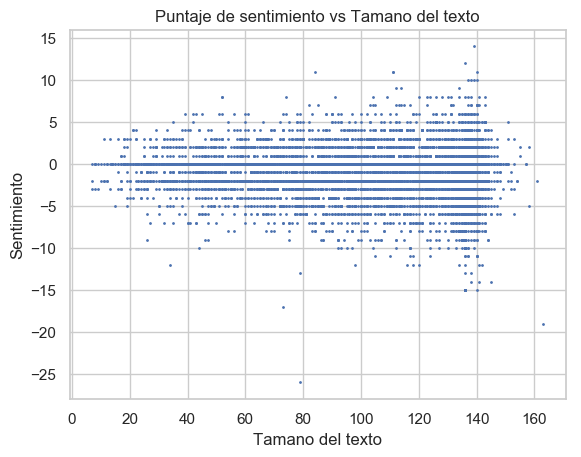

In [117]:
fig, ax = plt.subplots()
ax.scatter(tweet_list.text.map(lambda x: len(x)).tolist(), tweet_list.sentiment.tolist(), s=1)
plt.title("Puntaje de sentimiento vs Tamano del texto")
plt.xlabel("Tamano del texto")
plt.ylabel("Sentimiento")
plt.show()

### Observacion
A medida que los textos son mas largos, los sentimientos se alejan de la neutralidad

In [77]:
sentiment_by_target = tweet_list[['target', 'sentiment']].copy()
sentiment_by_target_1 = sentiment_by_target[sentiment_by_target.target == 1].sentiment
sentiment_by_target_1.describe()

count               3,271.00
mean                   -1.88
std                     2.94
min                   -15.00
25%                    -3.00
50%                    -2.00
75%                     0.00
max                    10.00
Name: sentiment, dtype: float64

In [71]:
sentiment_by_target_1.sum()

-6158.0

In [73]:
sentiment_by_target_0 = sentiment_by_target[sentiment_by_target.target == 0].sentiment
sentiment_by_target_0.describe()

count               4,342.00
mean                   -0.49
std                     2.87
min                   -26.00
25%                    -2.00
50%                     0.00
75%                     1.00
max                    14.00
Name: sentiment, dtype: float64

In [75]:
sentiment_by_target_0.sum()

-2116.0

### Observacion
Se puede ver claramente como los sentimientos negativos son predominantemente de los tweets verdaderos.

#### Grafico de sentimiento de tweets verdaderos

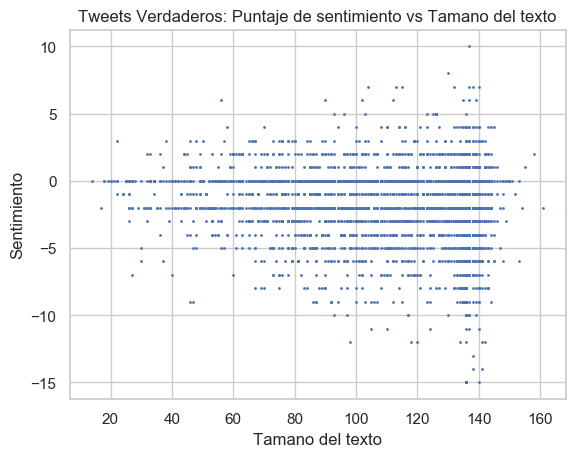

In [118]:
fig, ax = plt.subplots()
ax.scatter(tweet_list[tweet_list.target == 1].text.map(lambda x: len(x)).tolist(), tweet_list[tweet_list.target == 1].sentiment.tolist(), s=1)
plt.title("Tweets Verdaderos: Puntaje de sentimiento vs Tamano del texto")
plt.xlabel("Tamano del texto")
plt.ylabel("Sentimiento")
plt.show()

#### Grafico de sentimiento de tweets falsos

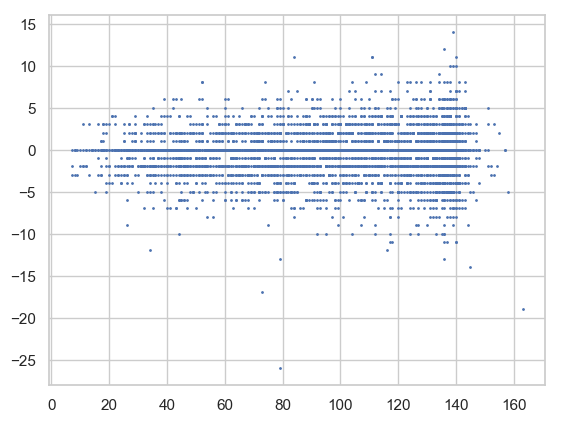

In [111]:
fig, ax = plt.subplots()
ax.scatter(tweet_list[tweet_list.target == 0].text.map(lambda x: len(x)).tolist(), tweet_list[tweet_list.target == 0].sentiment.tolist(), s=1)
plt.title("Tweets Falsos: Puntaje de sentimiento vs Tamano del texto")
plt.xlabel("Tamano del texto")
plt.ylabel("Sentimiento")
plt.show()

# Cloud Words

In [14]:
stopwords = set(STOPWORDS) # Set de datos de las palabras inutiles para el analisis de textos
def word_cloud(data, title=None):
    cloud = WordCloud(background_color = 'black',
                     stopwords = stopwords,
                     max_words = 200,
                     max_font_size = 40,
                     scale = 3).generate(str(data))
    fig = plt.figure(figsize=(15,15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.25)
        plt.imshow(cloud)
        plt.show()

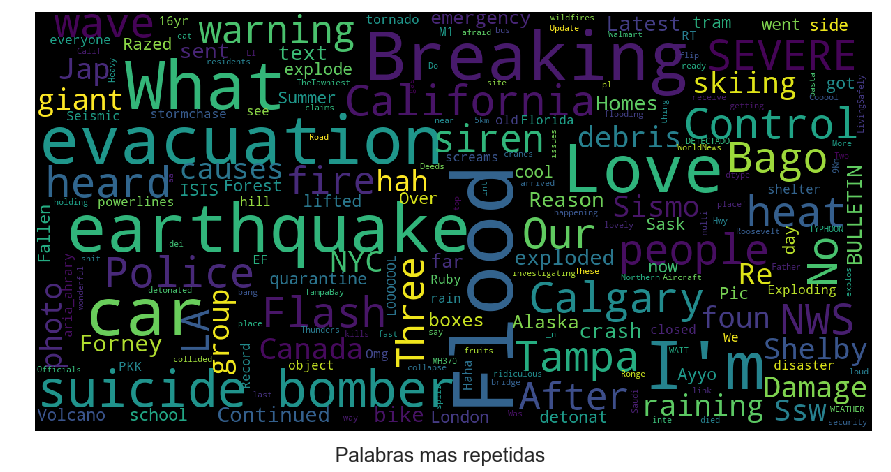

In [15]:
word_cloud(tweet_list.text,'Palabras mas repetidas')

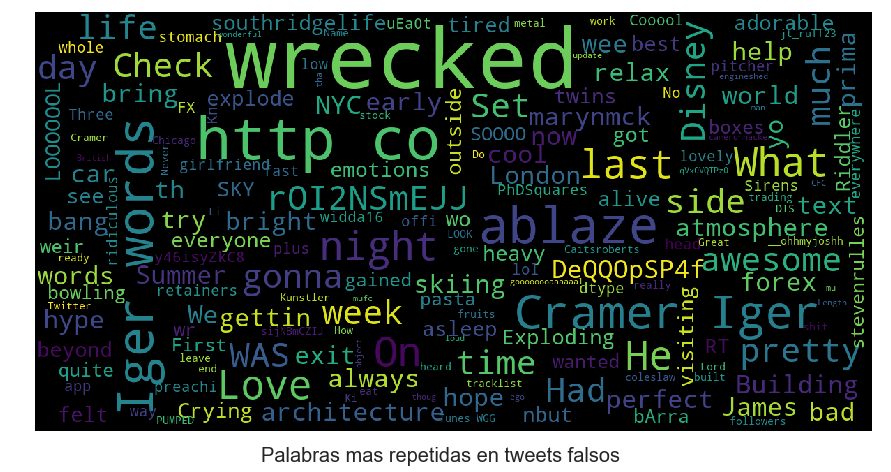

In [16]:
word_cloud(tweet_list[tweet_list.target==0].text,'Palabras mas repetidas en tweets falsos')

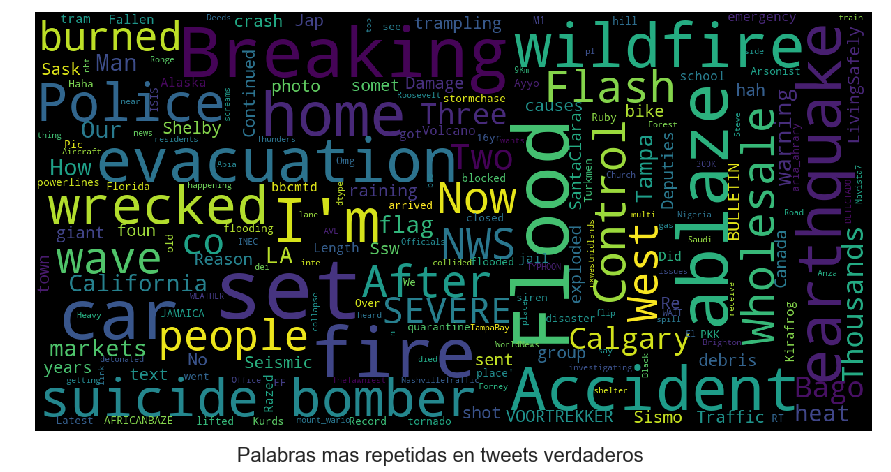

In [17]:
word_cloud(tweet_list[tweet_list.target==1].text,'Palabras mas repetidas en tweets verdaderos')

# Detalle del top 20 de palabras usadas (caracteres alfabeticos)

In [121]:
tweets_clear_text = tweet_list.text.apply(lambda x: ' '.join([word for word in x.split() if (word.lower() not in (stopwords) and word.isalpha())]))
top_20_word_list = Counter(" ".join(tweets_clear_text).split()).most_common(20)
piped_words = '|'.join([i[0] for i in top_20_word_list])
piped_words

'will|via|fire|people|one|new|got|now|New|know|video|going|California|killed|still|burning|see|back|go|time'

In [122]:
top_20_by_target_all = tweet_list[tweet_list.text.str.contains(piped_words)].groupby(['target']).size().reset_index(name='count')
top_20_by_target_all

,target,count
0,0,1743
1,1,1334


In [123]:
top_20_by_target = pd.DataFrame({'word': pd.Series([], dtype='str'), 'total_count': pd.Series([], dtype='int'), 'target_0': pd.Series([], dtype='int'), 'target_1': pd.Series([], dtype='int')})
top_20_by_target.word = [x[0] for x in top_20_word_list]

for index, word in enumerate(top_20_by_target.word):
    filtered_by_word = tweet_list[tweet_list.text.str.contains(word)]
    top_20_by_target.total_count[index] = filtered_by_word.shape[0]
    top_20_by_target.target_0[index] = filtered_by_word[filtered_by_word.target == 0].shape[0]
    top_20_by_target.target_1[index] = filtered_by_word[filtered_by_word.target == 1].shape[0]

top_20_by_target

,target_0,target_1,total_count,word
0,145.00,65.00,210.00,will
1,97.00,126.00,223.00,via
2,99.00,284.00,383.00,fire
3,72.00,93.00,165.00,people
4,405.00,201.00,606.00,one
5,148.00,115.00,263.00,new
6,95.00,35.00,130.00,got
7,228.00,99.00,327.00,now
8,123.00,198.00,321.00,New
9,90.00,35.00,125.00,know


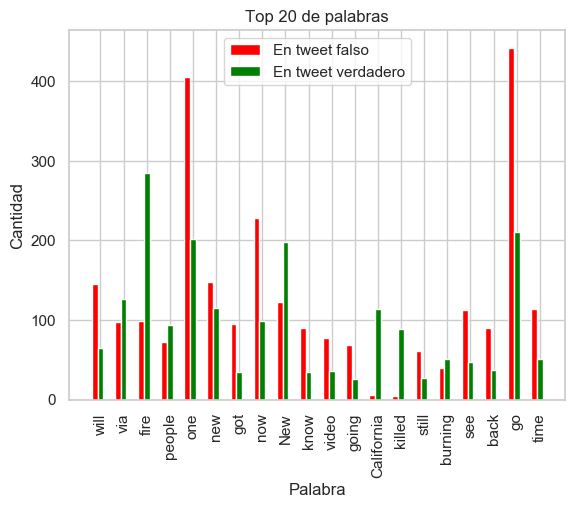

In [124]:
# bar graphs
fig, ax = plt.subplots()
x = np.arange(top_20_by_target.shape[0])
width = 0.25

target_0 = top_20_by_target.target_0.to_numpy();
target_1 = top_20_by_target.target_1.to_numpy();

ax.bar(x, target_0, width, color='red', label='En tweet falso')
ax.bar(x + width, target_1 , width, color='green', label='En tweet verdadero')
ax.set_xticks(x + width)
ax.set_xticklabels(top_20_by_target.word, rotation='vertical')
plt.title("Top 20 de palabras")
plt.xlabel("Palabra")
plt.ylabel("Cantidad")
ax.legend()
plt.show()

# Detalle del top 20 de palabras usadas (caracteres no alfabeticos)

In [125]:
tweets_clear_text = tweet_list.text.apply(lambda x: ' '.join([word for word in x.split() if (word.lower() not in (stopwords) and not word.isalpha())]))
top_20_word_list = Counter(" ".join(tweets_clear_text).split()).most_common(20)
safe_words = [re.escape(m[0]) for m in top_20_word_list]
piped_words = '|'.join(safe_words)
piped_words

'\\-|\\&amp\\;|\\?\\?|\\.\\.\\.|2|\\||\\?\\?\\?\\?|\\@YouTube|3|\\:|5|\\?\\?\\?\\?\\?\\?|4|\\\xc2\\\x89\\\xc3\\\x9b\\_|70|1|MH370\\:|\\\xc2\\\x89\\\xc3\\\x9b\\\xc3\\\x92|it\\.|\\?'

In [126]:
top_20_by_target = tweet_list[tweet_list.text.str.contains(piped_words)].groupby(['target']).size().reset_index(name='count')
top_20_by_target

,target,count
0,0,3080
1,1,2840


In [127]:
top_20_by_target = pd.DataFrame({'word': pd.Series([], dtype='str'), 'total_count': pd.Series([], dtype='int'), 'target_0': pd.Series([], dtype='int'), 'target_1': pd.Series([], dtype='int')})
top_20_by_target.word = [x[0] for x in top_20_word_list]
top_20_by_target

for index, word in enumerate(top_20_by_target.word):
    filtered_by_word = tweet_list[tweet_list.text.str.contains(re.escape(word))]
    top_20_by_target.total_count[index] = filtered_by_word.shape[0]
    top_20_by_target.target_0[index] = filtered_by_word[filtered_by_word.target == 0].shape[0]
    top_20_by_target.target_1[index] = filtered_by_word[filtered_by_word.target == 1].shape[0]

top_20_by_target

,target_0,target_1,total_count,word
0,606.00,685.00,"1,291.00",-
1,188.00,113.00,301.00,&amp;
2,418.00,116.00,534.00,??
3,385.00,593.00,978.00,...
4,644.00,703.00,"1,347.00",2
5,66.00,45.00,111.00,|
6,195.00,58.00,253.00,????
7,65.00,17.00,82.00,@YouTube
8,592.00,669.00,"1,261.00",3
9,"2,007.00","2,343.00","4,350.00",:


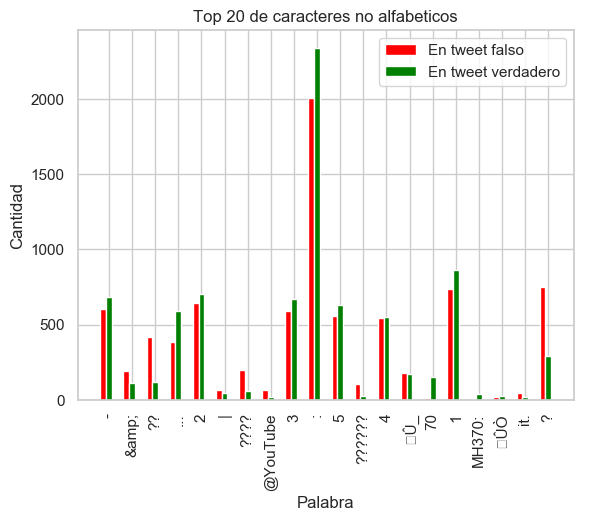

In [128]:
# bar graphs
fig, ax = plt.subplots()
x = np.arange(top_20_by_target.shape[0])
width = 0.25

target_0 = top_20_by_target.target_0.to_numpy();
target_1 = top_20_by_target.target_1.to_numpy();

ax.bar(x, target_0, width, color='red', label='En tweet falso')
ax.bar(x + width, target_1 , width, color='green', label='En tweet verdadero')
ax.set_xticks(x + width)
ax.set_xticklabels(map(unicode, top_20_by_target.word), rotation='vertical')
plt.title("Top 20 de caracteres no alfabeticos")
plt.xlabel("Palabra")
plt.ylabel("Cantidad")
ax.legend()
plt.show()

# Grafico de caracteres por tweets

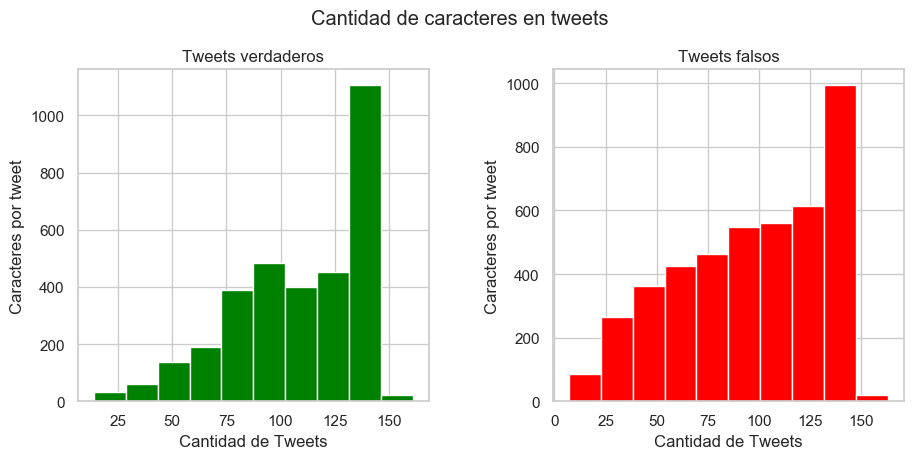

In [158]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet_list[tweet_list.target==1].text.str.len()
ax1.hist(tweet_len,color='green')
ax1.set_title('Tweets verdaderos')
ax1.set_xlabel("Cantidad de Tweets")
ax1.set_ylabel("Caracteres por tweet")
tweet_len=tweet_list[tweet_list.target==0].text.str.len()
ax2.hist(tweet_len,color='red')
ax2.set_title('Tweets falsos')
ax2.set_xlabel("Cantidad de Tweets")
ax2.set_ylabel("Caracteres por tweet")

fig.tight_layout(pad=3.0)
fig.suptitle('Cantidad de caracteres en tweets')
plt.show()

# Grafico de palabras por tweets

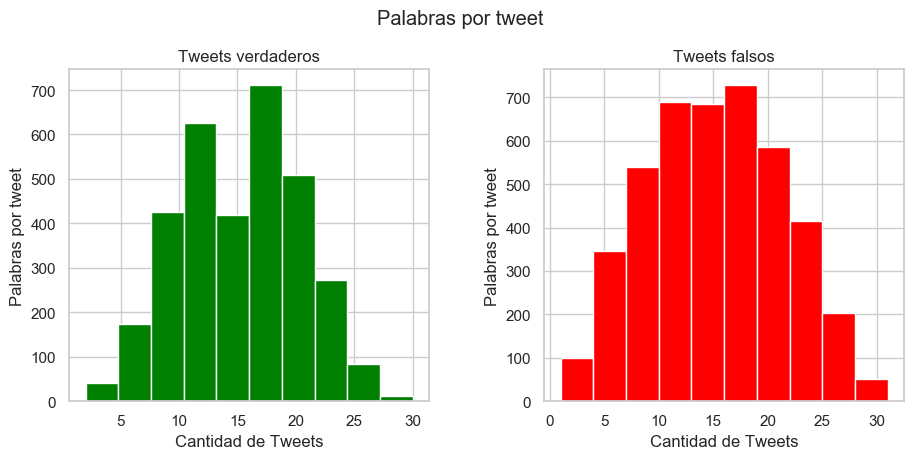

In [159]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_words = tweet_list[tweet_list.target==1].text.str.split().map(lambda x: len(x))
ax1.hist(tweet_words, color='green')
ax1.set_title('Tweets verdaderos')
ax1.set_xlabel("Cantidad de Tweets")
ax1.set_ylabel("Palabras por tweet")
tweet_words = tweet_list[tweet_list.target==0].text.str.split().map(lambda x: len(x))
ax2.hist(tweet_words, color='red')
ax2.set_title('Tweets falsos')
ax2.set_xlabel("Cantidad de Tweets")
ax2.set_ylabel("Palabras por tweet")

fig.tight_layout(pad=3.0)
fig.suptitle('Palabras por tweet')
plt.show()

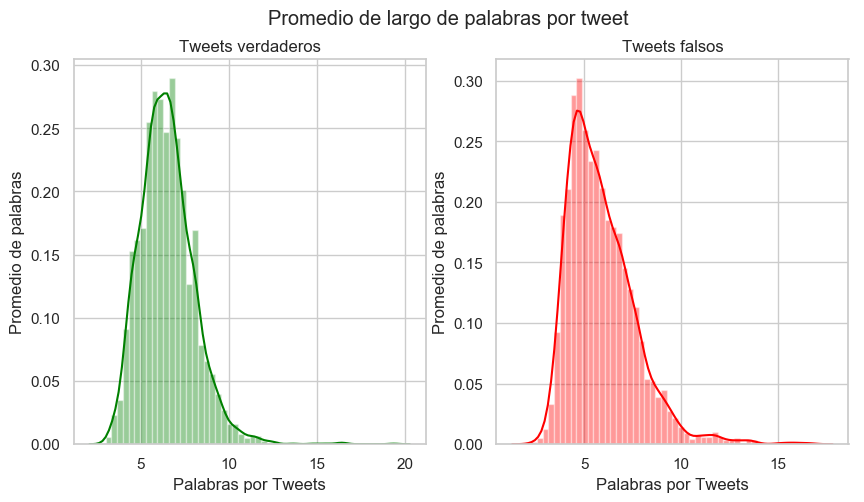

In [160]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
tweet_words = tweet_list[tweet_list.target==1].text.str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(tweet_words.map(lambda x: np.mean(x)), color='green')
plt.title('Tweets verdaderos')
plt.xlabel("Palabras por Tweets")
plt.ylabel("Promedio de palabras")
plt.subplot(1,2,2)
tweet_words = tweet_list[tweet_list.target==0].text.str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(tweet_words.map(lambda x: np.mean(x)), color='red')
plt.title('Tweets falsos')
plt.xlabel("Palabras por Tweets")
plt.ylabel("Promedio de palabras")

fig.tight_layout(pad=3.0)
plt.suptitle('Promedio de largo de palabras por tweet')
plt.show()